#  TP1 - Análisis de Plataforma de Ventas Online

## Aprendizaje de máquinas I

### Domenje, Carlos R.

Una plataforma de ventas online nos contrata para que realicemos un modelo que nos permita detectar un posible fraude dada cierta operación para ello contamos con un dataset

https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset

Utilizando los modelos de clasificación vistos hasta el momento generar un notebook que permita de ser posible resolver el problema que nos está planteando el cliente.

## 1. Análisis de Datos

En primer lugar se importa el dataset, para luego, a través de las diferentes funciones vistas en la cátedra poder realizar un analisis preliminar de los datos.

In [2]:
# Librerias a utilizar
import pandas as pd
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import scipy.stats as stats
# Seteamos 3 decimales para la muestra de datos en el dataset.
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Path del dataset a utilizar.
DATASET_PATH = "./data"

In [4]:
# Listado de archivos que se encuentran en el path
!ls {DATASET_PATH}

sales.csv


In [3]:
# Lectura del dataset
df = pd.read_csv("./data/sales.csv")

# Para obtener una primer aproximación de cada columna, 
# podemos utilizar la funcion head, que nos mostrará las 5 primeras filas con sus respectivas columnas del dataset
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0,0
1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0,0
2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0
3,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1,0
4,1,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0,0


In [4]:
# Realizamos una exploración de los datos con describe
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.000,6362620.000,6362620.000,6362620.000,6362620.000,6362620.000,6362620.000,6362620.000
mean,243.397,179861.904,833883.104,855113.669,1100701.667,1224996.398,0.001,0.000
std,142.332,603858.231,2888242.673,2924048.503,3399180.113,3674128.942,0.036,0.002
min,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,156.000,13389.570,0.000,0.000,0.000,0.000,0.000,0.000
50%,239.000,74871.940,14208.000,0.000,132705.665,214661.440,0.000,0.000
75%,335.000,208721.478,107315.175,144258.410,943036.708,1111909.250,0.000,0.000
max,743.000,92445516.640,59585040.370,49585040.370,356015889.350,356179278.920,1.000,1.000


In [5]:
# Verifico por datos nulos en cada columna.
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
# Tipos de datos que tenemos en el dataset

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
# Funcion para mostrar las distribuciones de las variables.

def display_dataset_distributions(dataset):
    fig = dataset.hist(xlabelsize=12, ylabelsize=12,figsize=(22,10))
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()

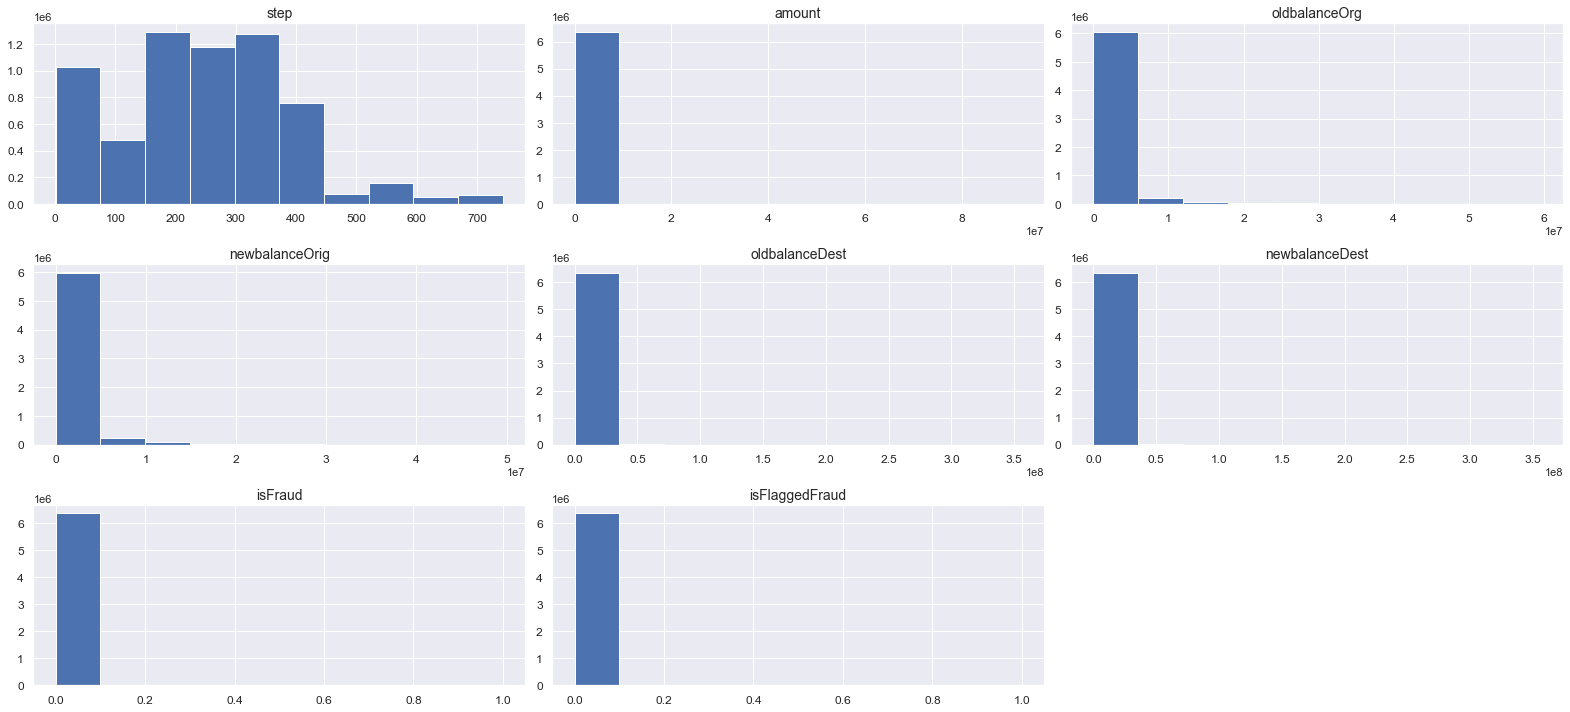

In [8]:
display_dataset_distributions(df)

<AxesSubplot:>

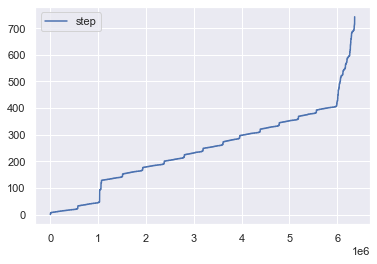

In [9]:
df.plot(kind='line', y='step')

<AxesSubplot:>

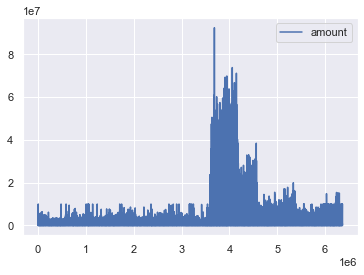

In [10]:
df.plot(kind='line', y='amount')

<AxesSubplot:>

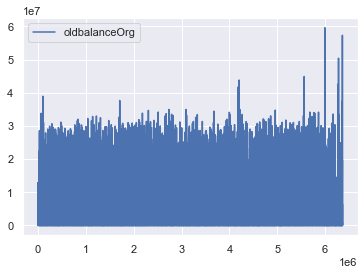

In [11]:
df.plot(kind='line',y='oldbalanceOrg')

<AxesSubplot:>

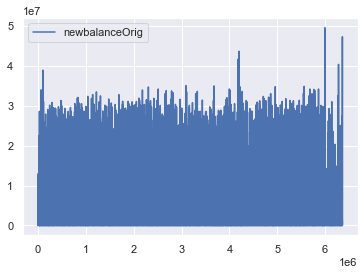

In [12]:
df.plot(kind='line', y='newbalanceOrig')

<AxesSubplot:>

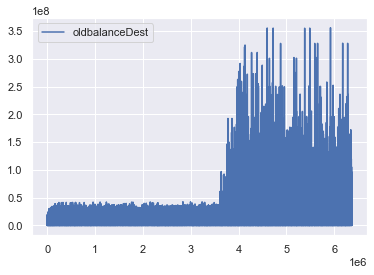

In [13]:
df.plot(kind='line', y='oldbalanceDest')

<AxesSubplot:>

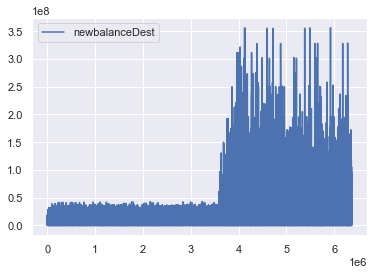

In [14]:
df.plot(kind='line', y='newbalanceDest')

In [18]:
# Observamos el balance entre la salida con fraude detectado. 
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

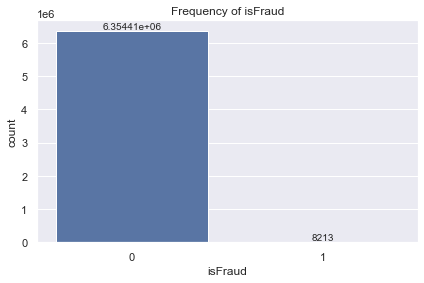

In [31]:
fig = plt.figure()
ax = sns.countplot(x='isFraud', data=df)
for container in ax.containers:
    ax.bar_label(container)
plt.tight_layout()
plt.title('Frequency of isFraud')
plt.show(fig)

In [19]:
# Observamos que la columna de fraude marcado solo tiene valores unicos iguales a cero. 
print(df['isFlaggedFraud'].value_counts(normalize=True))

0   1.000
1   0.000
Name: isFlaggedFraud, dtype: float64


<AxesSubplot:>

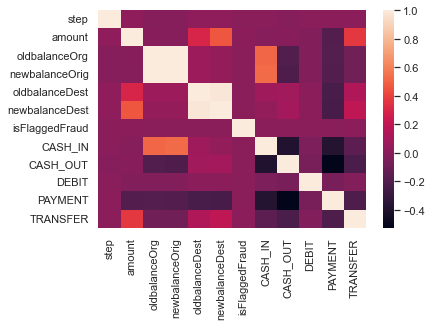

In [32]:
sns.heatmap(df.loc[:, df.columns != 'isFraud'].corr())

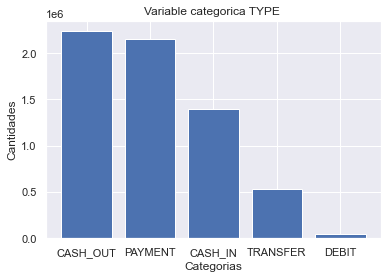

In [20]:
# La variable type, es de tipo categorica, y tiene las siguientes cantidades de datos por cada categoria.

type_feature = df['type'].value_counts()

plt.title('Variable categorica TYPE ')
plt.xlabel('Categorias')
plt.ylabel('Cantidades')
plt.bar(type_feature.index, type_feature.values)

plt.show()

In [21]:
# Creamos 4 columnas con la funcion get_dummies para reemplazar a la variable categorica.

dummyType = pd.get_dummies(df.type)

dummyType.head()

,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,0,1
3,0,1,0,0,0
4,0,0,0,1,0


In [22]:
# Concatenamos las nuevas columnas al dataframe y tiramos la variable type y isFlaggedFraud (contiene solo ceros)

df = pd.concat([df,dummyType], axis='columns')
newDF = df.drop(['type', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis='columns')
newDF.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.640,170136.000,160296.360,0.000,0.000,0,0,0,0,1,0
1,1,1864.280,21249.000,19384.720,0.000,0.000,0,0,0,0,1,0
2,1,181.000,181.000,0.000,0.000,0.000,1,0,0,0,0,1
3,1,181.000,181.000,0.000,21182.000,0.000,1,0,1,0,0,0
4,1,11668.140,41554.000,29885.860,0.000,0.000,0,0,0,0,1,0


## Predicción utilizando Regresión Lineal

Importamos los paquetes que queremos utilizar

In [23]:
#Importamos las bibliotecas que usaremos para hacer las prediciones.

from sklearn.linear_model import LinearRegression

In [24]:
# Separamos el dataset en train y test
# Tomamos el dataset sin la columna que vamos a predecir.

X_train, X_test, y_train, y_test = train_test_split(\
    newDF.drop(['isFraud'], axis=1),\
    newDF['isFraud'],\
    stratify = newDF['isFraud'],\
    random_state=0)

# chequeamos la presencia relativa de cada clase y el tamaño de los datasets
print('Entrenamiento:',X_train.shape)
print('Testeo:',X_test.shape)
print('\nClases train:')
print(y_train.value_counts(normalize=True))
print('\nClases test:')
print(y_test.value_counts(normalize=True))


Entrenamiento: (4771965, 11)
Testeo: (1590655, 11)

Clases train:
0   0.999
1   0.001
Name: isFraud, dtype: float64

Clases test:
0   0.999
1   0.001
Name: isFraud, dtype: float64


### Regresión logística

La siguiente función implementa una regresión logística optimizando el hiperparámetro de regularización por cross validation.

Luego imprime las métricas principales de evaluación en problemas de clasificación.

In [28]:


def logistic_regression_report(X_train,X_test,y_train,y_test):
    
    scaler=StandardScaler()  
    
    X_train_sc=scaler.fit_transform(X_train) # Estandarizamos los datos     
    X_test_sc=scaler.transform(X_test)
        
    model=LogisticRegression(max_iter=1000)
    
    model.fit(X_train_sc,y_train)
    y_pred=model.predict(X_test_sc)
    y_proba=model.predict_proba(X_test_sc)
    
    print(classification_report(y_test,y_pred))
    
    print('Area bajo la curva ROC:',np.round(roc_auc_score(y_test,y_proba[:,1]),4))
    
    precision, recall,threshold=precision_recall_curve(y_test,y_proba[:,1]);

    print('Area bajo la curva Precision-Recall:',np.round(auc(recall,precision),4))

    plot_confusion_matrix(model,X_test_sc,y_test,cmap='Blues');

    print("Accuracy : {:0.4f}".format(accuracy_score(y_test,y_pred)))
    return

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.92      0.44      0.59      2053

    accuracy                           1.00   1590655
   macro avg       0.96      0.72      0.80   1590655
weighted avg       1.00      1.00      1.00   1590655

Area bajo la curva ROC: 0.9823
Area bajo la curva Precision-Recall: 0.6243
Accuracy : 0.9992


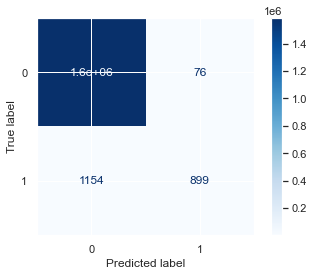

In [29]:
logistic_regression_report(X_train,X_test,y_train,y_test)

In [41]:
from imblearn.under_sampling import RandomUnderSampler
undersampler=RandomUnderSampler(sampling_strategy='majority')

X_train_us,y_train_us=undersampler.fit_resample(X_train,y_train);

print('Composición del training set:')
print(y_train_us.value_counts())

print('\nComposición del test set:')
print(y_test.value_counts())

Composición del training set:
0    6160
1    6160
Name: isFraud, dtype: int64

Composición del test set:
0    1588602
1       2053
Name: isFraud, dtype: int64


              precision    recall  f1-score   support

           0       1.00      0.93      0.96   1588602
           1       0.02      0.91      0.03      2053

    accuracy                           0.93   1590655
   macro avg       0.51      0.92      0.50   1590655
weighted avg       1.00      0.93      0.96   1590655

Area bajo la curva ROC: 0.9784
Area bajo la curva Precision-Recall: 0.5503


/opt/miniconda3/envs/tp-ia/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Accuracy : 0.9300


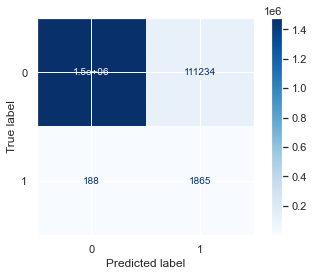

In [21]:
logistic_regression_report(X_train_us, X_test, y_train_us, y_test)

In [29]:
from imblearn.over_sampling import RandomOverSampler
oversampler=RandomOverSampler(sampling_strategy='minority');

X_train_os,y_train_os=oversampler.fit_resample(X_train,y_train);

print('Composición del training set:')
print(y_train_os.value_counts())

print('\nComposición del test set:')
print(y_test.value_counts())


Composición del training set:
0    4765805
1    4765805
Name: isFraud, dtype: int64

Composición del test set:
0    1588602
1       2053
Name: isFraud, dtype: int64


              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1588602
           1       0.02      0.94      0.05      2053

    accuracy                           0.95   1590655
   macro avg       0.51      0.95      0.51   1590655
weighted avg       1.00      0.95      0.97   1590655

Area bajo la curva ROC: 0.9893
Area bajo la curva Precision-Recall: 0.5812
Accuracy : 0.9508


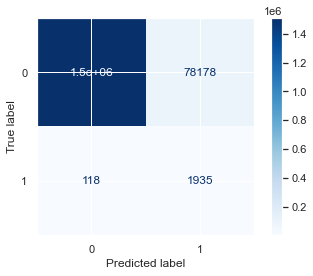

In [31]:
logistic_regression_report(X_train_os,X_test,y_train_os,y_test)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1588602
           1       0.02      0.94      0.05      2053

    accuracy                           0.95   1590655
   macro avg       0.51      0.95      0.51   1590655
weighted avg       1.00      0.95      0.97   1590655

Area bajo la curva ROC: 0.9892228533718491
Area bajo la curva Precision-Recall: 0.5812333536583696


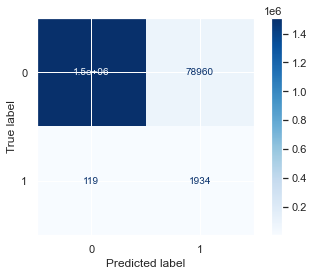

In [42]:
# Class weighting

model = LogisticRegression(class_weight = 'balanced')

scaler=StandardScaler()

X_train_sc=scaler.fit_transform(X_train);
X_test_sc=scaler.transform(X_test);

model.fit(X_train_sc,y_train)
y_pred = model.predict(X_test_sc)
pred_probas = model.predict_proba(X_test_sc);

print(classification_report(y_test,y_pred))
plot_confusion_matrix(model,X_test_sc,y_test,cmap='Blues');

print('Area bajo la curva ROC:',roc_auc_score(y_test,pred_probas[:,1]))

precision, recall,threshold=precision_recall_curve(y_test,pred_probas[:,1]);

print('Area bajo la curva Precision-Recall:',auc(recall,precision))


## Conclusión

Los valores de la diagonal principal a=1.5e6 y d=1934 se corresponden con los valores estimados de forma correcta por el modelo, tanto los verdaderos positivos_ TP(d), como los verdaderos negativos_TN (a).

La otra diagonal, por tanto, representa los casos en los que el modelo se ha equivocado (c=119 falsos negativos_FN, b=78960 falsos positivos_FP).

La exactitud (o accuracy) representa el porcentaje de predicciones correctas frente al total. Por tanto, es el cociente entre los casos bien clasificados por el modelo (verdaderos positivos y verdaderos negativos, es decir, los valores en la diagonal de la matriz de confusión), y la suma de todos los casos.

Sin embargo, cuando un conjunto de datos es poco equilibrado, no es una métrica útil.

La precisión, (o“precision”) se refiere a lo cerca que está el resultado de una predicción del valor verdadero. Por tanto, es el cociente entre los casos positivos bien clasificados por el modelo y el total de predicciones positivas. 

La sensibilidad (o recall) representa la tasa de verdaderos positivos (True Positive Rate) ó TP. Es la proporción entre los casos positivos bien clasificados por el modelo, respecto al total de positivos. 

Representa, como hemos dicho antes, la habilidad del modelo de detectar los casos relevantes.

## Decision Tree



In [45]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

treeModel = DecisionTreeClassifier()
# Entrenamos el modelo con los datos desbalanceados.
treeModel.fit(X_train,y_train)

y_pred = treeModel.predict(X_test)


In [46]:
print(treeModel.score(X_test,y_test))

0.9997064102523803


In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.89      0.88      0.89      2053

    accuracy                           1.00   1590655
   macro avg       0.95      0.94      0.94   1590655
weighted avg       1.00      1.00      1.00   1590655



In [43]:
# Entrenamos el modelo con los datos con Undersampling
treeModel.fit(X_train_us,y_train_us)

y_pred = treeModel.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99   1588602
           1       0.09      0.99      0.16      2053

    accuracy                           0.99   1590655
   macro avg       0.54      0.99      0.58   1590655
weighted avg       1.00      0.99      0.99   1590655



In [44]:
# Entrenamos el modelo con los datos con Oversampling
treeModel.fit(X_train_os,y_train_os)

y_pred = treeModel.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.89      0.85      0.87      2053

    accuracy                           1.00   1590655
   macro avg       0.95      0.92      0.94   1590655
weighted avg       1.00      1.00      1.00   1590655

